In [1]:
import sys
print(sys.executable)

/Users/anjanaparepalli/Desktop/3rdYearMaterial/Semester V/2. Fundamentals of Machine Learning/Laboratory/Mini Project/.venv/bin/python


In [2]:
!python3 --version

Python 3.11.9


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve

2025-10-25 21:14:18.350436: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Loading the cleaned dataset of UAV network data
cleaned_uav_network_df = pd.read_csv("Cleaned_UAV_Network_Dataset.csv")

print("Columns of cleaned dataset...\n")
cleaned_uav_network_df.info()

Columns of cleaned dataset...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54774 entries, 0 to 54773
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   frame.len               54774 non-null  float64
 1   wlan.duration           54774 non-null  float64
 2   wlan.frag               54774 non-null  float64
 3   llc.type                54774 non-null  float64
 4   ip.hdr_len              54774 non-null  float64
 5   ip.len                  54774 non-null  float64
 6   ip.ttl                  54774 non-null  float64
 7   ip.proto                54774 non-null  float64
 8   tcp.hdr_len             54774 non-null  float64
 9   tcp.flags               54774 non-null  float64
 10  tcp.window_size         54774 non-null  float64
 11  udp.length              54774 non-null  float64
 12  data.len                54774 non-null  float64
 13  time_since_last_packet  54774 non-null  float64
 14  class  

In [5]:
print("Statistical summary of cleaned dataset...\n")
cleaned_uav_network_df.describe()

Statistical summary of cleaned dataset...



,frame.len,wlan.duration,wlan.frag,llc.type,ip.hdr_len,ip.len,ip.ttl,ip.proto,tcp.hdr_len,tcp.flags,tcp.window_size,udp.length,data.len,time_since_last_packet
count,54774.000000,54774.00000,54774.000000,54774.000000,54774.000000,5.477400e+04,54774.000000,54774.000000,54774.000000,54774.000000,54774.000000,54774.000000,54774.000000,54774.000000
mean,69.233487,115.52346,2300.825319,357.358802,25.864388,3.766453e+08,47.773414,6.149734,1.659648,0.276785,2555.670430,19.052415,23.567039,0.105798
std,112.519518,152.94823,6117.247607,757.783524,51.818721,9.660565e+08,92.894270,39.766253,7.436355,5.545356,12540.535924,54.753226,54.985718,0.590235
min,-107.000000,-100.00000,-50.000000,-1.000000,-200.000000,-2.000000e+02,0.000000,-4783.000000,-43.750186,-68.801801,-176.275862,0.000000,0.000000,0.000000
25%,26.000000,0.00000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002721
50%,26.000000,44.00000,0.000000,8.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003374
75%,98.000000,314.00000,41.750000,66.000000,20.000000,1.950000e+02,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.005190
max,1569.000000,320.00000,21356.000000,2054.000000,305.000000,4.294753e+09,372.000000,321.950000,62.783226,75.309914,64240.000000,282.000000,192.000000,28.844855


In [6]:
cleaned_uav_network_df.tail()

,frame.len,wlan.duration,wlan.frag,llc.type,ip.hdr_len,ip.len,ip.ttl,ip.proto,tcp.hdr_len,tcp.flags,tcp.window_size,udp.length,data.len,time_since_last_packet,class
54769,45.0,0.0,0.0,0.0,71.0,74.0,58.0,311.97,58.075944,48.138578,-59.598106,0.0,0.0,0.003374,attack
54770,45.0,0.0,0.0,0.0,71.0,74.0,57.0,311.88,57.939034,48.275077,-61.352988,0.0,0.0,0.003374,attack
54771,45.0,0.0,0.0,0.0,71.0,74.0,57.0,311.86,57.824911,48.446966,-62.564276,0.0,0.0,0.003374,attack
54772,46.0,0.0,0.0,0.0,71.0,74.0,57.0,311.93,57.733356,48.479274,-63.347861,0.0,0.0,0.003374,attack
54773,51.0,1.0,0.0,0.0,70.0,73.0,57.0,311.89,57.513146,47.816084,-62.818343,0.0,0.0,0.003374,attack


In [7]:
# Select the features and the prediction target
X = cleaned_uav_network_df.drop(columns = ["class"])
y = cleaned_uav_network_df["class"]

# Select the observations where the network is benign
X_benign = X[y == "benign"]

# Scale the features
scaler = StandardScaler()
X_benign_scaled = scaler.fit_transform(X_benign)
X_scaled = scaler.transform(X) # Used for reconstruction testing

# Split the benign network data subset into training and validation sets
X_train, X_val = train_test_split(X_benign_scaled, test_size = 0.2, random_state = 42)

In [8]:
EPOCHS = 100
BATCH_SIZE = 64

# This is a vanilla autoencoder - I chose to use an autoencoder for this project because Shrijani and I used a U-Net autoencoder during 
# the Honeywell 48-hour hackathon event. I chose the topic of detecting intrusion in UAV networks because it was mentioned in my Honours 
# course, Advanced Computer Networks (Semester V).
def build_autoencoder(hp):
    # Tune the bottleneck dimension
    bottleneck_dim = hp.Int("bottleneck_dim", min_value = 8, max_value = 64, step = 8)

    # Tune the learning rate
    learning_rate = hp.Choice("learning_rate", [0.0001, 0.001, 0.005])

    input_dim = X_train.shape[1]
    input_layer = Input(shape = (input_dim,))

    # Encoder
    encoded = Dense(64, activation = "relu")(input_layer)
    encoded = Dense(32, activation = "relu")(encoded)
    encoded = Dense(bottleneck_dim, activation = "relu")(encoded)

    # Decoder
    decoded = Dense(32, activation = "relu")(encoded)
    decoded = Dense(64, activation = "relu")(decoded)
    decoded = Dense(input_dim, activation = "linear")(decoded)

    # Combine the encoder and decoder blocks into one autoencoder
    autoencoder = Model(inputs = input_layer, outputs = decoded)
    autoencoder.compile(optimizer = Adam(learning_rate = learning_rate), loss = "mse")

    return autoencoder

# Initialize the Keras tuner
tuner = kt.RandomSearch(
    build_autoencoder, 
    objective = "val_loss", # This is the same as "best-validation-loss" in the MATLAB Coursera course I took 
    max_trials = 10, # Number of different combinations to try
    executions_per_trial = 1, 
    directory = "autoencoder_tuning", 
    project_name = "uav_network_anomaly_tuning"
)

# Search for the best combination of hyperparameters (randomly, because an exhaustive search is too time-consuming)
tuner.search(
    X_train, X_train, 
    epochs = EPOCHS, 
    batch_size = BATCH_SIZE, 
    validation_data = (X_val, X_val), 
    verbose = 1
)

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print("Best bottleneck dimensionality: ", best_hps.get("bottleneck_dim"))
print("Best learning rate: ", best_hps.get("learning_rate"))

# Evaluate on the validation set
best_model = tuner.get_best_models(num_models = 1)[0]
val_loss = best_model.evaluate(X_val, X_val, verbose = 0)
print("Validation loss of the best model: {:.5f}".format(val_loss))

Reloading Tuner from autoencoder_tuning/uav_network_anomaly_tuning/tuner0.json
Best bottleneck dimensionality:  48
Best learning rate:  0.001


/Users/anjanaparepalli/Desktop/3rdYearMaterial/Semester V/2. Fundamentals of Machine Learning/Laboratory/Mini Project/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Validation loss of the best model: 0.00008


In [9]:
# Predicting whether a given query is benign or an attack

# Compute reconstruction errors to detect intrusion
X_pred = best_model.predict(X_scaled)
mse = np.mean(np.square(X_scaled - X_pred), axis = 1) # Using mean squared error

1712/1712 ━━━━━━━━━━━━━━━━━━━━ 1s 519us/step


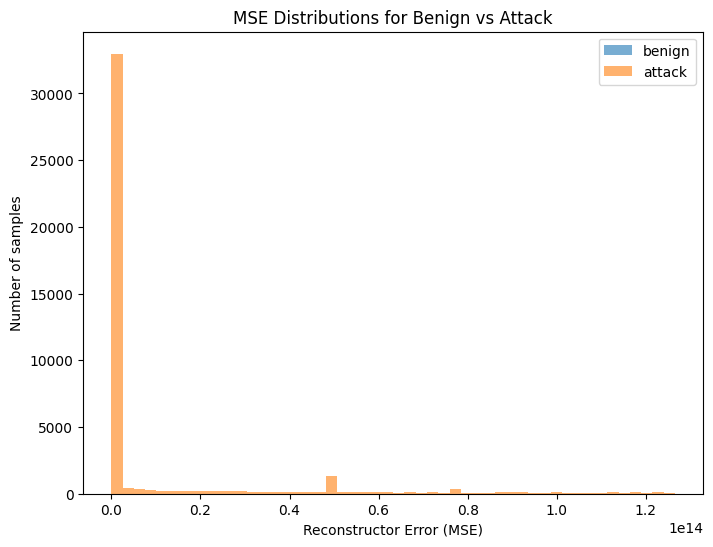

In [10]:
# Visualizing the reconstruction error distributions
plt.figure(figsize = (8, 6))
plt.hist(mse[y == "benign"], bins = 50, alpha = 0.6, label = "benign")
plt.hist(mse[y == "attack"], bins = 50, alpha = 0.6, label = "attack")
plt.xlabel("Reconstructor Error (MSE)")
plt.ylabel("Number of samples")
plt.title("MSE Distributions for Benign vs Attack")
plt.legend()
plt.show()

In [11]:
THRESHOLD_PERCENTILE = 85

# Choosing a minimum threshold to classify as attack
threshold = np.percentile(mse[y == "benign"], THRESHOLD_PERCENTILE)
print("Reconstruction error threshold:", threshold)

Reconstruction error threshold: 8.398215493839836e-05


In [12]:
# If MSE crosses the reconstruction error threshold, then the network is under attack
y_pred = np.where(mse > threshold, "attack", "benign")

# Print the number of predicted benign and attack labels
results = pd.DataFrame({"Actual": y, "Predicted": y_pred})
print(results["Predicted"].value_counts())

Predicted
attack    39244
benign    15530
Name: count, dtype: int64


In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Binary true labels: benign = 0, attack = 1
y_bin = np.where(y == "benign", 0, 1)
y_pred_bin = np.where(y_pred == "attack", 1, 0)

print("Accuracy: {:.5f}%".format(accuracy_score(y_bin, y_pred_bin) * 100))
print("Precision: {:.5f}%".format(precision_score(y_bin, y_pred_bin) * 100))
print("Recall: {:.5f}%".format(recall_score(y_bin, y_pred_bin) * 100))
print("F1 Score: {:.5f}%".format(f1_score(y_bin, y_pred_bin) * 100))

Accuracy: 89.17187%
Precision: 94.75589%
Recall: 90.56723%
F1 Score: 92.61422%


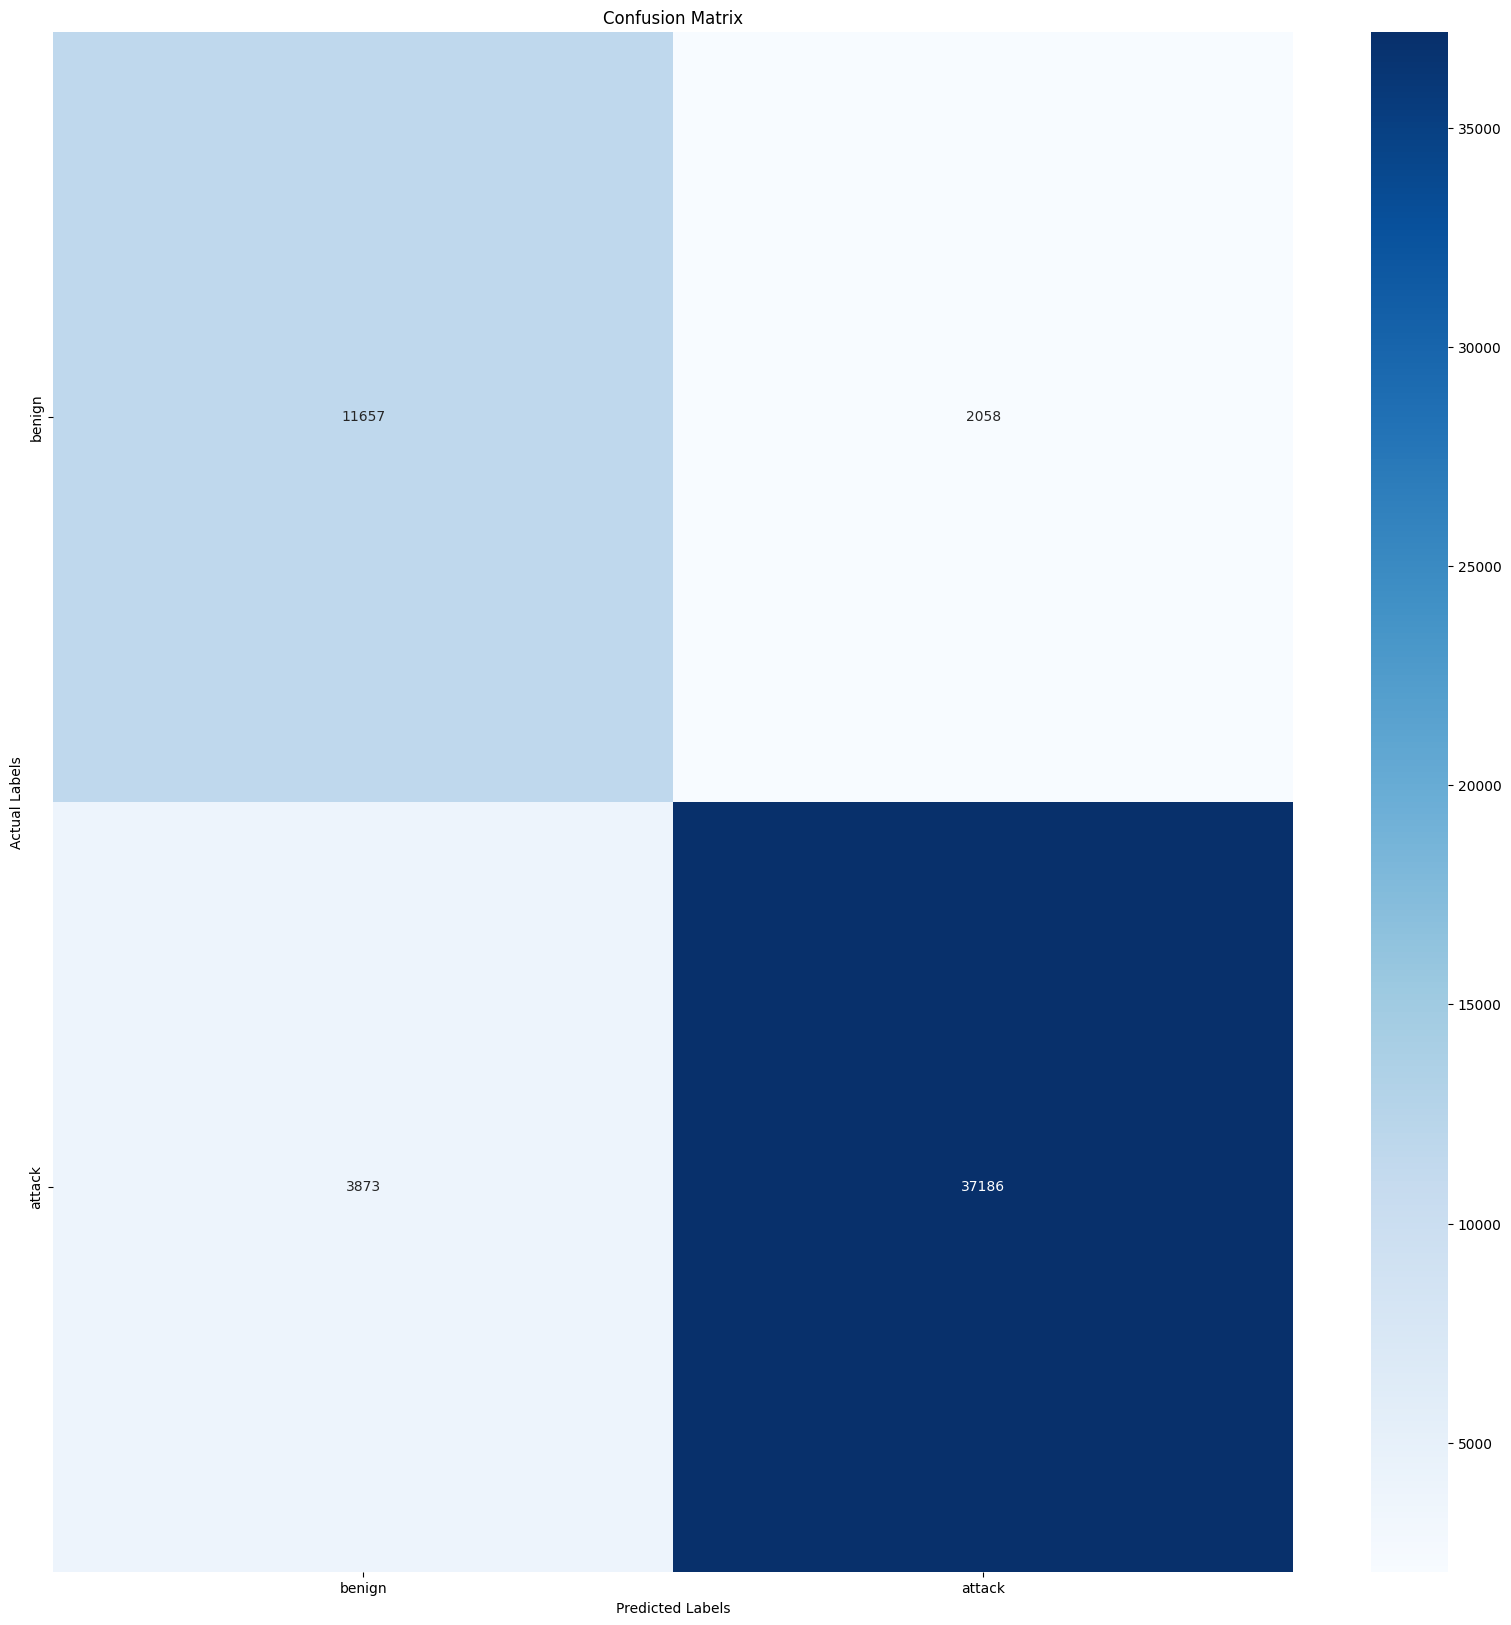

In [16]:
# Confusion matrix of the autoencoder
cm = confusion_matrix(y, y_pred, labels = ["benign", "attack"])

plt.figure(figsize = (20, 20))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels = ["benign", "attack"], yticklabels = ["benign", "attack"])
plt.ylabel("Actual Labels")
plt.xlabel("Predicted Labels")
plt.title("Confusion Matrix")
plt.show()

In [17]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

      attack       0.95      0.91      0.93     41059
      benign       0.75      0.85      0.80     13715

    accuracy                           0.89     54774
   macro avg       0.85      0.88      0.86     54774
weighted avg       0.90      0.89      0.89     54774



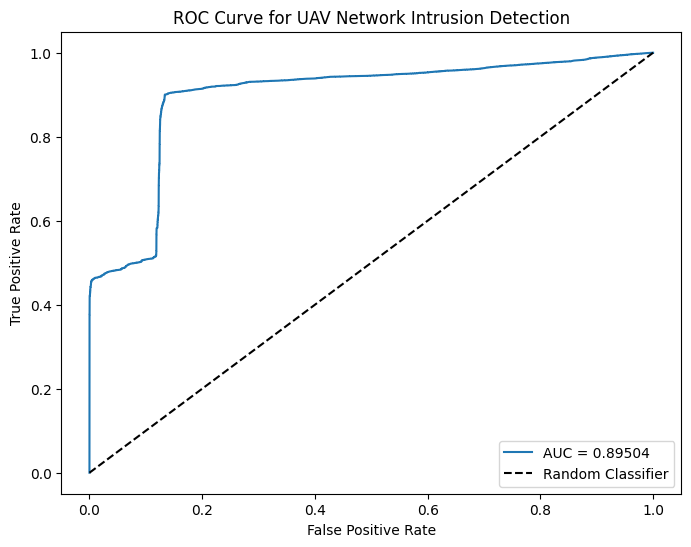

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Reconstruction errors are used as scores
y_score = mse

# Compute ROC
fpr, tpr, thresholds = roc_curve(y_bin, y_score)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, label = f"AUC = {roc_auc:.5f}")
plt.plot([0, 1], [0, 1], "k--", label = "Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for UAV Network Intrusion Detection")
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import roc_auc_score
print("Area under the ROC Curve: {:.5f}".format(roc_auc_score(y_bin, y_score)))

Area under the ROC Curve: 0.89504
